In [28]:
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
from sklearn.metrics import matthews_corrcoef, classification_report
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
% matplotlib inline

# specify GPU device
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [6]:
DATA_DIR="."
import pickle
# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])
    
    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, input_tensor_train, target_tensor_train, query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, input_tensor_test, target_tensor_test, query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what does the fare code f mean EOS
Query vector:  [178 916 376 827 414 309 411 585 179]
Intent label:  abbreviation
Slot text:  O O O O O O B-fare_basis_code O O
Slot vector:  [128, 128, 128, 128, 128, 128, 39, 128, 128]
**************************************************************************
Query text: BOS what kind of airplane is flight ua 281 from boston to denver EOS
Query vector:  [178 916 513 646 201 498 428 885  84 444 266 851 351 179]
Intent label:  aircraft
Slot text:  O O O O O O O B-airline_code B-flight_number O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 1, 43, 128, 48, 128, 78, 128]
**************************************************************************
Query text: BOS i would like a flight from baltimore to san francisco on twa with a stop in denver EOS
Query vector:  [178 479 932 545 180 42

In [0]:
from collections import defaultdict
D = defaultdict(int)
for item in intent_data_label_train:
  D[item] += 1

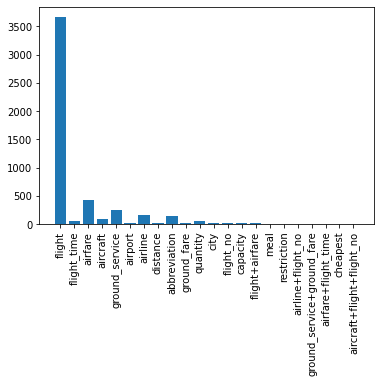

In [8]:
import matplotlib.pyplot as plt


plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)),[i2in_train[key] for key in list(D.keys())], rotation = 90)
plt.savefig('Intent_train.png')

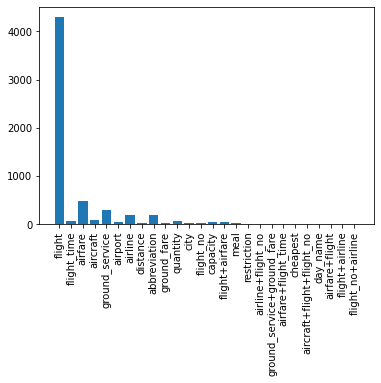

In [9]:
for item in intent_data_label_test:
  D[item] += 1
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)),[i2in_train[key] for key in list(D.keys())], rotation = 90)
plt.savefig('Intent_test.png')

In [10]:


#
# queries are stored in the variable query_data_train
# correct intent labels are stored in the variablae labels
#

# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]


# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
for i in range(3):
  print("Input sentence:\n", sentences[i])
  print ("Tokenized Sentence:\n",tokenized_texts[i])

100%|██████████| 231508/231508 [00:00<00:00, 315542.02B/s]


Input sentence:
 [CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]
Tokenized Sentence:
 ['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']
Input sentence:
 [CLS]  what flights are available from pittsburgh to baltimore on thursday morning  [SEP]
Tokenized Sentence:
 ['[CLS]', 'what', 'flights', 'are', 'available', 'from', 'pittsburgh', 'to', 'baltimore', 'on', 'thursday', 'morning', '[SEP]']
Input sentence:
 [CLS]  what is the arrival time in san francisco for the 755 am flight leaving washington  [SEP]
Tokenized Sentence:
 ['[CLS]', 'what', 'is', 'the', 'arrival', 'time', 'in', 'san', 'francisco', 'for', 'the', '75', '##5', 'am', 'flight', 'leaving', 'washington', '[SEP]']


In [0]:
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [0]:
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, intent_data_label_train, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= 26)
model.cuda()


100%|██████████| 407873900/407873900 [00:36<00:00, 11284621.50B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
  ## TRAINING
def training_model(train_dataloader, optimizer): 
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = (t.to(device) for t in batch)
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
Epoch:  25%|██▌       | 1/4 [03:52<11:37, 232.47s/it]

Train loss: 0.4634826960574303


Epoch:  50%|█████     | 2/4 [07:44<07:44, 232.40s/it]

Train loss: 0.10404205473938159


Epoch:  75%|███████▌  | 3/4 [11:37<03:52, 232.40s/it]

Train loss: 0.049022984451481275


Epoch: 100%|██████████| 4/4 [15:29<00:00, 232.37s/it]

Train loss: 0.04194922713296754


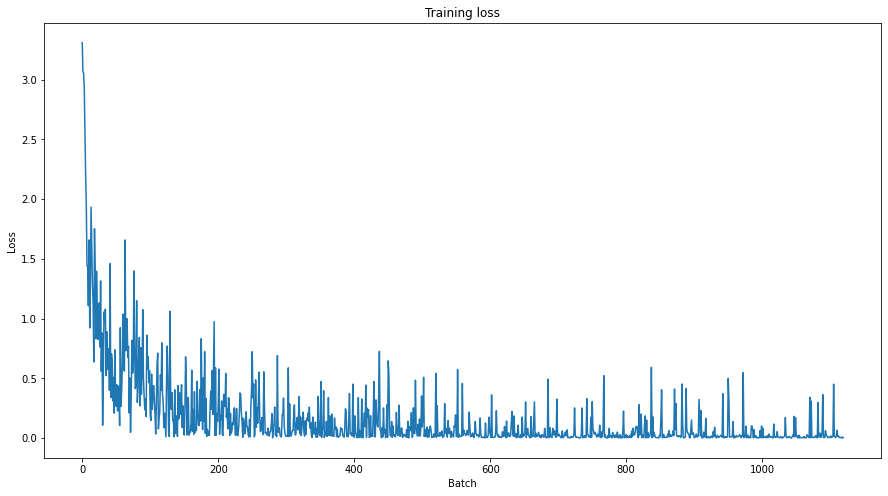

In [17]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
 training_model(train_dataloader, optimizer)
       
 
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()



In [0]:
 ## VALIDATION
def evaluate(validation_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  evalute_list_accuracy = []
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU

    # Unpack the inputs from our dataloader
    (b_input_ids, b_input_mask, b_labels) = (t.to(device) for t in batch)
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    evalute_list_accuracy.append(tmp_eval_accuracy)
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  return evalute_list_accuracy


In [19]:
validatiom_accuracy =  evaluate(validation_dataloader)

Validation Accuracy: 0.9921875


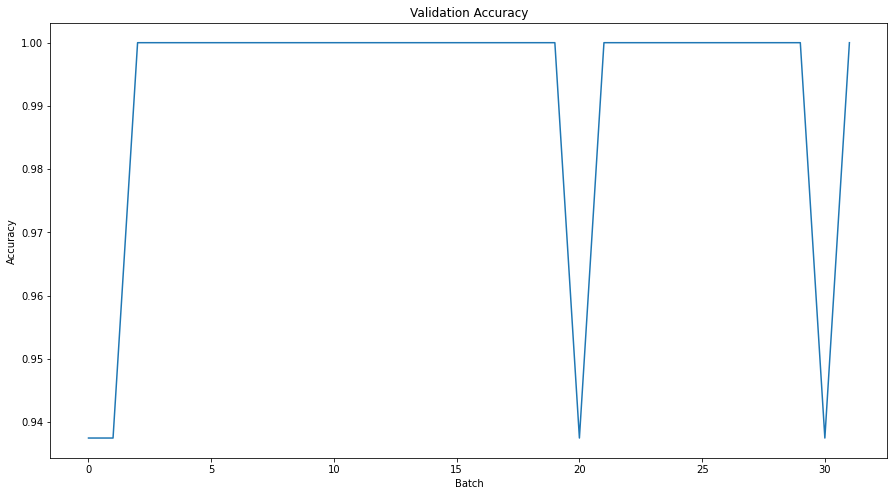

In [20]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Validation Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(validatiom_accuracy)
plt.show()

In [0]:
def testing_model(query_data_test, intent_data_label_test):
  # load test data
  sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]
  labels = intent_data_label_test

  # tokenize test data
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  MAX_LEN = 128
  # Pad our input tokens
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                            maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Create attention masks
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

  # create test tensors
  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
  prediction_labels = torch.tensor(labels)
  batch_size = 32  
  prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  ## Prediction on test set
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  predictions , true_labels = [], []
  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
  # Import and evaluate each test batch using Matthew's correlation coefficient
  from sklearn.metrics import matthews_corrcoef

  matthews_set = []
  for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                  np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)
  # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
  flat_predictions = [item for sublist in predictions for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  flat_true_labels = [item for sublist in true_labels for item in sublist]

  print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))
  return flat_predictions, flat_true_labels

In [22]:
flat_predictions,flat_true_labels =  testing_model(query_data_test, intent_data_label_test)

Classification accuracy using BERT Fine Tuning: 95.19%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
testconf_labels = set(intent_data_label_test.tolist())
indexes_confmatrix = [i2in_test[label] for label in testconf_labels]

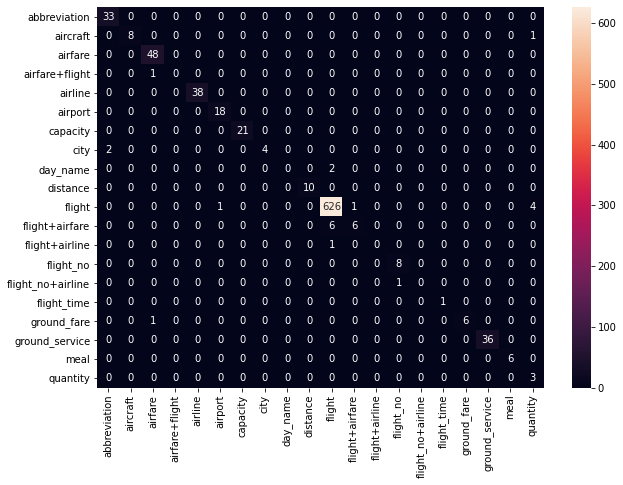

In [24]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(flat_true_labels,flat_predictions)
df_cm = pd.DataFrame(cm, index = indexes_confmatrix,
                  columns = indexes_confmatrix)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")

In [0]:
def demo(query_data_test):
  # load test data
  sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]

  # tokenize test data
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  MAX_LEN = 128
  # Pad our input tokens
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                            maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  print(tokenized_texts)
  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Create attention masks
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

  # create demo tensors
  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
  batch_size = 1  
  prediction_data = TensorDataset(prediction_inputs, prediction_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  ## Prediction on test set
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  predictions = []
  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()  
    # Store predictions and true labels
    predictions.append(logits)

  flat_predictions = [item for sublist in predictions for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  print(flat_predictions)
  return flat_predictions[0]

In [0]:
query = ' I want to catch a flight from Miami to Chicago '

In [38]:
# demo_query = np.asarray([query])
demo_predicted = demo(np.asarray([query], dtype='<U176'))
print("label: ", i2in_test[demo_predicted])

[['[CLS]', 'i', 'want', 'to', 'catch', 'a', 'flight', 'from', 'miami', 'to', 'chicago', '[SEP]']]
[14]
label:  flight


In [30]:
print(classification_report(flat_predictions, flat_true_labels))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.89      1.00      0.94         8
           3       1.00      0.96      0.98        50
           4       0.00      0.00      0.00         0
           6       1.00      1.00      1.00        38
           8       1.00      0.95      0.97        19
           9       1.00      1.00      1.00        21
          11       0.67      1.00      0.80         4
          12       0.00      0.00      0.00         0
          13       1.00      1.00      1.00        10
          14       0.99      0.99      0.99       635
          15       0.50      0.86      0.63         7
          16       0.00      0.00      0.00         0
          17       1.00      0.89      0.94         9
          18       0.00      0.00      0.00         0
          19       1.00      1.00      1.00         1
          20       0.86      1.00      0.92         6
          21       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
